In [1]:
import sys
import os

# 1. Récupère le chemin absolu du dossier courant du notebook
current_dir = os.getcwd()

# 2. Récupère le chemin du dossier parent (le dossier 'Segmentation')
parent_dir = os.path.dirname(current_dir)

# 3. Ajoute ce dossier parent au path de Python
sys.path.append(parent_dir)

print(f"Dossier ajouté au path : {parent_dir}")
print("Tu peux maintenant importer config, data, et models.")


import config
import data.dataset as dataset
from models.lightning import HemorrhageModel


Dossier ajouté au path : /store/home/tibia/Projet_Hemorragie/Seg_hemorragie/Segmentation
Tu peux maintenant importer config, data, et models.


2026-02-06 12:28:25.251439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 12:28:25.293523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compati

In [3]:
import os
import torch
import pytorch_lightning as pl
import nibabel as nib
import numpy as np
import pandas as pd 
from pathlib import Path
from monai.data import DataLoader, PersistentDataset
from tqdm import tqdm
import monai.transforms as T
import config 
import data.dataset as dataset
import data.transform as T_seg
from models.lightning import HemorrhageModel
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, DiceHelper




def remove_small_objects(pred_map, min_size=50):
    """
    Supprime les petites composantes connectées (faux positifs isolés)
    
    Args:
        pred_map: numpy array (H, W, D) avec les labels de classe
        min_size: taille minimale en voxels pour conserver une région
    
    Returns:
        pred_map nettoyé
    """
    cleaned = np.zeros_like(pred_map)
    
    # Pour chaque classe (sauf background = 0)
    for class_id in range(1, 6):  # Classes 1-5
        # Masque binaire de la classe
        mask = (pred_map == class_id)
        
        # Labellisation des composantes connectées
        labeled, num_features = ndi.label(mask)
        
        # Garder seulement les grandes régions
        for region_id in range(1, num_features + 1):
            region_mask = (labeled == region_id)
            if region_mask.sum() >= min_size:
                cleaned[region_mask] = class_id
    
    return cleaned


def save_nifti(data, affine, filename, output_dir):

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    if data.ndim == 4:
        data = np.transpose(data, (1, 2, 3, 0)) # (C, D, H, W) -> (D, H, W, C)
        
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, os.path.join(output_dir, filename))
    
def main():
    cfg = config.CONFIG
    pl.seed_everything(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Configuration
    ckpt_path = os.path.join(cfg['dataset']['save_dir'], "checkpoints", "best_model.ckpt")
    output_seg_dir = os.path.join(cfg['dataset']['save_dir'], "predictions_nifti")
    
    print(f" Démarrage de l'inférence UNIQUE (Images + Métriques)")
    print(f"Chargement : {ckpt_path}")

    # 2. Modèle
    model = HemorrhageModel.load_from_checkpoint(ckpt_path, num_steps=1000)
    model.eval()
    model.to(device)
    dice_helper = DiceHelper(
    include_background=False,
    softmax=True,
    reduction="none",
    
)
    # 3. Données (Test)
    test_files = dataset.get_data_files(
        f"{cfg['dataset']['dataset_dir']}/test/img",
        f"{cfg['dataset']['dataset_dir']}/test/seg"
    )
    
    test_dataset = PersistentDataset(
        test_files,
        transform=T_seg.get_val_transforms(cfg), #meme transfo que val
        cache_dir=os.path.join(cfg['dataset']['save_dir'], "cache_test_inference")
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
     
     
    # Test rapide : afficher la shape d'une image avant les transfos
    load= T.LoadImageD(keys=['image']) 
    test_img = load( test_files[-1])  # pour afficher les infos de l'image
    print (f" shape image test : {test_img['image'].shape}")
    # print(f"keys test img : {list(test_img.keys())}")
    # print(f"Métadonnées de l'image : {test_img['image'].meta.keys()}")
    
   
    
    #print du datalaoder
    
    # print(f"Démarrage du DataLoader pour test...")
    # for i, data in enumerate(test_loader):
    #     print(f" Batch {i} :")
    #     for key in data.keys():
    #         print(f"  - {key} : type {type(data[key])}, shape {data[key].shape if isinstance(data[key], torch.Tensor) else 'N/A'}")
    #         print(f"    Métadonnées ({key}.meta) : {data[key].meta.keys() if hasattr(data[key], 'meta') else 'N/A'}")
    #     if i >= 2:  # Limite à 3 batches pour éviter trop d'output
    #         break

   
#     # 2. TRANSFORM & INVERTER
    val_transforms = T_seg.get_val_transforms(cfg)
    
#     # L'inverter a besoin de savoir quelles transfos inverser
    inverter = T.Invertd(
        keys=["pred"],
        transform=val_transforms,
        orig_keys=["image"],
        nearest_interp=False, # On garde les probas fluides pour l'inversion
        to_tensor=True
    )
    
    results = [] # Pour stocker dice_scores
    # 4. Boucle d'inférence
    with torch.no_grad():
        for batch in tqdm(test_loader):
            
            images = batch["image"].to(device)
            
#             # B. Inférence (Sliding Window)
            batch["pred"] = sliding_window_inference(images, roi_size=(64, 64, 64),  sw_batch_size=2,  predictor=model, overlap=0.5,mode="gaussian")
            scores, _ = dice_helper(batch["pred"], batch["seg"].to(device)) # _ car get_non_nans =true  dans le dicehelper
            print (f" scores shape : {scores.shape}")
            dice_scores = {}
            #for class_idx in range(3):  # In_house
            for class_idx in range(5):  # MBH
                dice_scores[f"dice_c{class_idx+1}"] = scores[0, class_idx].item()
                
        
            
            print (f" shape pred avant inversion : {batch['pred'].shape}")
           
            decollated_batch = decollate_batch(batch)
            pred_inversed = inverter(decollated_batch[0]) #va l'appliquer automatiquement à la bonne clé 
            
            pred = pred_inversed["pred"]
            print (f" shape pred inversed : {pred.shape}") 
            argmax_map = torch.argmax(pred, dim=0).cpu().numpy().astype(np.uint8)
            affine = pred.meta["affine"]
            
            filename =Path(decollated_batch[0]["image"].meta["filename_or_obj"]).name
          

            row = {
                "filename": filename,
            }
            row.update(dice_scores)

            results.append(row)
            save_nifti(argmax_map, affine, f"PRED_{filename}", output_seg_dir)
            df = pd.DataFrame(results)
     # 5. Sauvegarde des résultats dans un CSV pour inférence per patient       
    csv_path = os.path.join(cfg['dataset']['save_dir'], "inference_results_per_patient.csv")
    df.to_csv(csv_path, index=False)

    print(f"✅ CSV sauvegardé : {csv_path}")
   
if __name__ == "__main__":
    main()
            


Seed set to 42


 Démarrage de l'inférence UNIQUE (Images + Métriques)
Chargement : /home/tibia/Projet_Hemorragie/MBH_multitaskjgvjhg_cases_Vf/checkpoints/best_model.ckpt
BasicUNet features: (32, 32, 64, 128, 256, 32).
 shape image test : torch.Size([512, 512, 32])


  0%|          | 0/38 [00:00<?, ?it/s]/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 198, 206, 157])


  3%|▎         | 1/38 [00:01<00:47,  1.30s/it]

 shape pred inversed : torch.Size([6, 512, 512, 30])


  5%|▌         | 2/38 [00:01<00:32,  1.10it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 198, 230, 138])
 shape pred inversed : torch.Size([6, 512, 512, 28])


  8%|▊         | 3/38 [00:02<00:26,  1.30it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 203, 199, 155])
 shape pred inversed : torch.Size([6, 512, 512, 30])


 11%|█         | 4/38 [00:03<00:24,  1.39it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 208, 210, 156])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 13%|█▎        | 5/38 [00:03<00:23,  1.41it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 228, 207, 147])
 shape pred inversed : torch.Size([6, 512, 512, 31])


 16%|█▌        | 6/38 [00:04<00:21,  1.48it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 201, 220, 157])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 18%|█▊        | 7/38 [00:05<00:21,  1.43it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 256, 255, 136])
 shape pred inversed : torch.Size([6, 512, 512, 23])


 21%|██        | 8/38 [00:05<00:20,  1.49it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 207, 211, 154])
 shape pred inversed : torch.Size([6, 512, 512, 38])


 24%|██▎       | 9/38 [00:06<00:18,  1.55it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 193, 204, 157])
 shape pred inversed : torch.Size([6, 512, 512, 30])


 26%|██▋       | 10/38 [00:07<00:18,  1.50it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 245, 251, 151])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 29%|██▉       | 11/38 [00:07<00:17,  1.55it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 198, 220, 136])
 shape pred inversed : torch.Size([6, 512, 512, 44])


 32%|███▏      | 12/38 [00:08<00:17,  1.48it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 214, 246, 166])
 shape pred inversed : torch.Size([6, 512, 512, 34])


 34%|███▍      | 13/38 [00:09<00:15,  1.58it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 220, 203, 145])
 shape pred inversed : torch.Size([6, 512, 512, 30])


 37%|███▋      | 14/38 [00:09<00:16,  1.43it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 231, 239, 165])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 39%|███▉      | 15/38 [00:10<00:15,  1.53it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 201, 213, 158])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 42%|████▏     | 16/38 [00:11<00:14,  1.55it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 211, 233, 157])
 shape pred inversed : torch.Size([6, 512, 512, 30])


 45%|████▍     | 17/38 [00:11<00:13,  1.54it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 209, 219, 166])
 shape pred inversed : torch.Size([6, 512, 512, 35])


 47%|████▋     | 18/38 [00:12<00:12,  1.55it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 209, 254, 156])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 50%|█████     | 19/38 [00:12<00:11,  1.63it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 202, 198, 155])
 shape pred inversed : torch.Size([6, 512, 512, 31])


 53%|█████▎    | 20/38 [00:13<00:11,  1.56it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 251, 231, 148])
 shape pred inversed : torch.Size([6, 512, 512, 29])


 55%|█████▌    | 21/38 [00:14<00:10,  1.63it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 206, 220, 147])
 shape pred inversed : torch.Size([6, 512, 512, 37])


 58%|█████▊    | 22/38 [00:14<00:10,  1.54it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 249, 227, 149])
 shape pred inversed : torch.Size([6, 512, 512, 30])


 61%|██████    | 23/38 [00:15<00:10,  1.37it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 248, 235, 186])
 shape pred inversed : torch.Size([6, 512, 512, 38])


 63%|██████▎   | 24/38 [00:16<00:11,  1.22it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 234, 250, 206])
 shape pred inversed : torch.Size([6, 512, 512, 42])


 66%|██████▌   | 25/38 [00:17<00:10,  1.28it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 249, 231, 147])
 shape pred inversed : torch.Size([6, 512, 512, 28])


 68%|██████▊   | 26/38 [00:18<00:08,  1.38it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 202, 228, 135])
 shape pred inversed : torch.Size([6, 512, 512, 26])


 71%|███████   | 27/38 [00:18<00:08,  1.30it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 245, 251, 176])
 shape pred inversed : torch.Size([6, 512, 512, 36])


 74%|███████▎  | 28/38 [00:19<00:07,  1.41it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 198, 223, 156])
 shape pred inversed : torch.Size([6, 512, 512, 39])


 76%|███████▋  | 29/38 [00:20<00:06,  1.34it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 251, 231, 161])
 shape pred inversed : torch.Size([6, 512, 512, 33])


 79%|███████▉  | 30/38 [00:20<00:05,  1.46it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 202, 205, 154])
 shape pred inversed : torch.Size([6, 512, 512, 31])


 82%|████████▏ | 31/38 [00:21<00:04,  1.65it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 200, 203, 128])
 shape pred inversed : torch.Size([6, 512, 512, 26])


 84%|████████▍ | 32/38 [00:21<00:03,  1.79it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 188, 184, 156])
 shape pred inversed : torch.Size([6, 512, 512, 32])


 87%|████████▋ | 33/38 [00:22<00:02,  1.69it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 192, 249, 186])
 shape pred inversed : torch.Size([6, 512, 512, 38])


 89%|████████▉ | 34/38 [00:22<00:02,  1.75it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 209, 219, 136])
 shape pred inversed : torch.Size([6, 512, 512, 26])


 92%|█████████▏| 35/38 [00:23<00:01,  1.80it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 201, 221, 137])
 shape pred inversed : torch.Size([6, 512, 512, 25])


 95%|█████████▍| 36/38 [00:24<00:01,  1.75it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 200, 204, 158])
 shape pred inversed : torch.Size([6, 512, 512, 31])


 97%|█████████▋| 37/38 [00:24<00:00,  1.73it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 197, 203, 156])
 shape pred inversed : torch.Size([6, 512, 512, 30])


100%|██████████| 38/38 [00:25<00:00,  1.64it/s]

 scores shape : torch.Size([1, 5])
 shape pred avant inversion : torch.Size([1, 6, 210, 235, 156])
 shape pred inversed : torch.Size([6, 512, 512, 32])


100%|██████████| 38/38 [00:25<00:00,  1.50it/s]

✅ CSV sauvegardé : /home/tibia/Projet_Hemorragie/MBH_multitaskjgvjhg_cases_Vf/inference_results_per_patient.csv


In [17]:
import nibabel as nib
from pathlib import Path

print("="*60)
print("📊 SHAPES DES PRÉDICTIONS")
print("="*60)

pred_dir = Path("/home/tibia/Projet_Hemorragie/MBH_multitaskjgvjhg_cases_Vf/predictions")
for nifti_file in sorted(pred_dir.glob("*.nii.gz")):
    img = nib.load(nifti_file)
    print(f"{nifti_file.name:60s} → {img.shape}")

print("\n" + "="*60)
print("📊 SHAPES DES GROUND TRUTH")
print("="*60)

gt_dir = Path("/home/tibia/Projet_Hemorragie/Split_Final_Stratified/test/seg")
for nifti_file in sorted(gt_dir.glob("*.nii.gz")):
    img = nib.load(nifti_file)
    print(f"{nifti_file.name:60s} → {img.shape}")

📊 SHAPES DES PRÉDICTIONS
MBH_SEG_2025_LLG_2025_06_12_ID_02b882cc_ID_a4892e60ae.nii.gz → (512, 512, 30)
MBH_SEG_2025_LLG_2025_06_12_ID_10beb45f_ID_7184e80f09.nii.gz → (512, 512, 28)
MBH_SEG_2025_LLG_2025_06_12_ID_1cbe2853_ID_37afefdc7c.nii.gz → (512, 512, 30)
MBH_SEG_2025_LLG_2025_06_12_ID_268b38fe_ID_d747ae3ffb.nii.gz → (512, 512, 32)
MBH_SEG_2025_LLG_2025_06_12_ID_2872834a_ID_542e9d00da.nii.gz → (512, 512, 31)
MBH_SEG_2025_LLG_2025_06_12_ID_2e21c3f3_ID_bc8f99a0cc.nii.gz → (512, 512, 32)
MBH_SEG_2025_LLG_2025_06_12_ID_3343ddf2_ID_fddff2e9c1.nii.gz → (512, 512, 23)
MBH_SEG_2025_LLG_2025_06_12_ID_3bda60be_ID_067209cc9a.nii.gz → (512, 512, 38)
MBH_SEG_2025_LLG_2025_06_12_ID_3e481fc5_ID_750530c215.nii.gz → (512, 512, 30)
MBH_SEG_2025_LLG_2025_06_12_ID_55742eb7_ID_7d5ad548ca.nii.gz → (512, 512, 32)
MBH_SEG_2025_LLG_2025_06_12_ID_56faaf6f_ID_dd8f688dff.nii.gz → (512, 512, 44)
MBH_SEG_2025_LLG_2025_06_12_ID_5910d129_ID_094eb98167.nii.gz → (512, 512, 34)
MBH_SEG_2025_LLG_2025_06_12_ID_7860208e

/tmp/ipykernel_2026662/55711328.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Classe', y='Dice Score', data=df_melted,


✅ Graphique sauvegardé : /home/tibia/Projet_Hemorragie/MBH_multitaskjgvjhg_cases_Vf/dice_distribution_plot.png


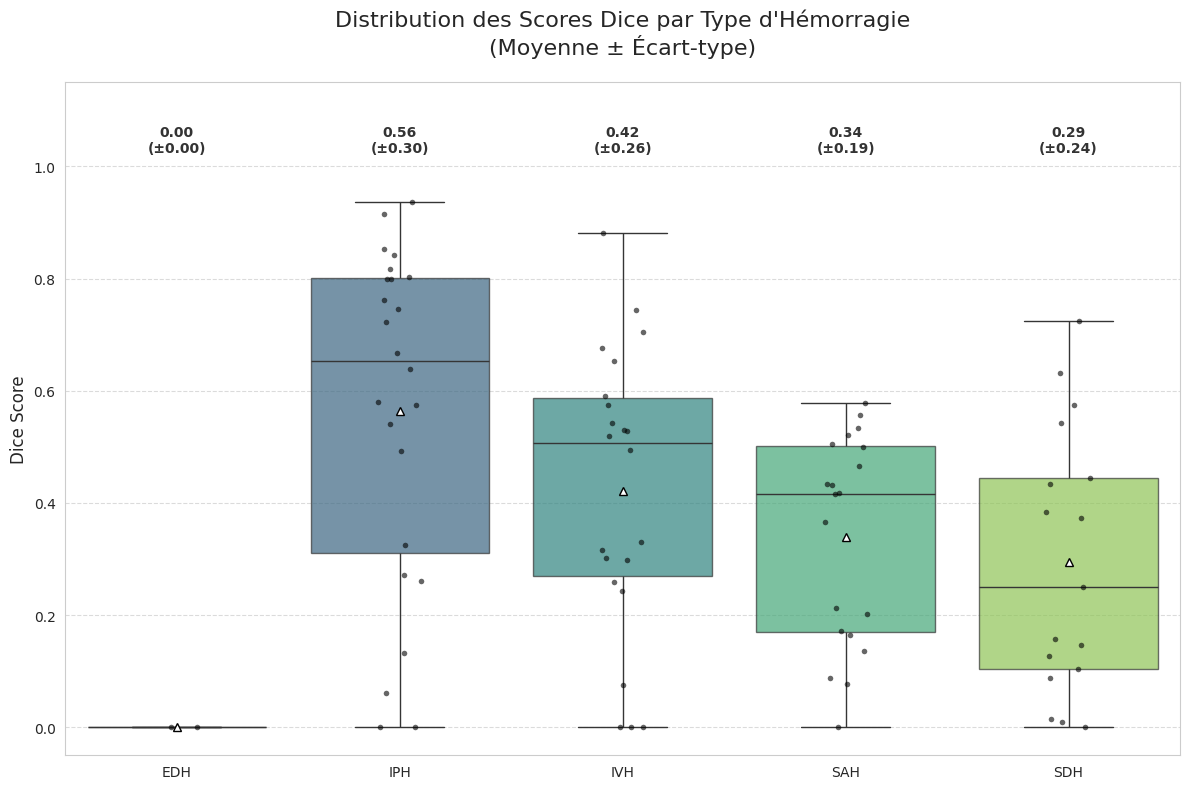

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import config 

# --- CONFIGURATION ---
# Remplace par le chemin réel de ton CSV généré à l'étape précédente
csv_path = os.path.join(config.CONFIG['dataset']['save_dir'], "inference_results_per_patient.csv")
output_plot = os.path.join(config.CONFIG['dataset']['save_dir'], "dice_distribution_plot.png")

# Mapping des noms de classes (pour que ce soit joli sur le graphe)
# class_map = {
#     'dice_c1': 'ICH',
#     'dice_c2': 'IVH ',
#     'dice_c3': 'PHE'
# }
class_map = {
    'dice_c1': 'EDH',
    'dice_c2': 'IPH',
    'dice_c3': 'IVH',
    'dice_c4': 'SAH',
    'dice_c5': 'SDH'
}

def plot_dice_distribution():
    # 1. Chargement
    if not os.path.exists(csv_path):
        print(f" Fichier introuvable : {csv_path}")
        return

    df = pd.read_csv(csv_path)
    
    # On vire la colonne filename pour les calculs, mais on la garde en tête si besoin
    # On transforme le tableau en format "Long" pour Seaborn
    # (Colonne 1: Type d'Hémorragie, Colonne 2: Score Dice)
    df_melted = df.melt(id_vars=['filename'], var_name='Classe', value_name='Dice Score')
    
    # On renomme les classes avec le dictionnaire
    df_melted['Classe'] = df_melted['Classe'].map(class_map)
    
    # Nettoyage : Si des classes inconnues traînent (ex: background ignoré), on les vire
    df_melted = df_melted.dropna(subset=['Classe'])

    # 2. Configuration du style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))

    # 3. Création du Boxplot (La structure globale)
    # showmeans=True ajoute un petit triangle pour la moyenne (en plus de la ligne médiane)
    ax = sns.boxplot(x='Classe', y='Dice Score', data=df_melted, 
                     showmeans=True, 
                     meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black"},
                     palette="viridis", boxprops=dict(alpha=.7))

    # 4. Ajout du Stripplot (Les points individuels)
    # C'est ça qui montre la vérité crue : chaque point est un patient.
    sns.stripplot(x='Classe', y='Dice Score', data=df_melted, 
                  color='black', size=4, alpha=0.6, jitter=True)

    # 5. Calcul et affichage des Stats textuelles (Moyenne ± Std) au-dessus
    stats = df_melted.groupby('Classe')['Dice Score'].agg(['mean', 'std'])
    
    # On récupère l'ordre des barres affichées par Seaborn
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    for i, label in enumerate(labels):
        if label in stats.index:
            mean_val = stats.loc[label, 'mean']
            std_val = stats.loc[label, 'std']
            
            # Affichage du texte au-dessus de la boîte
            text = f"{mean_val:.2f}\n(±{std_val:.2f})"
            ax.text(i, 1.02, text, ha='center', va='bottom', fontweight='bold', color='#333333')

    # 6. Finitions
    plt.title('Distribution des Scores Dice par Type d\'Hémorragie\n(Moyenne ± Écart-type)', fontsize=16, pad=20)
    plt.ylabel('Dice Score', fontsize=12)
    plt.xlabel('')
    plt.ylim(-0.05, 1.15) # Un peu de marge pour le texte
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Sauvegarde et Affichage
    plt.tight_layout()
    plt.savefig(output_plot, dpi=300)
    print(f"✅ Graphique sauvegardé : {output_plot}")
    plt.show()

if __name__ == "__main__":
    plot_dice_distribution()

In [16]:
from monai.data import DataLoader, PersistentDataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import data.dataset as dataset
import data.transform as T_seg

import config 
from monai.transforms import SaveImage
from models.lightning import HemorrhageModel
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor,EarlyStopping
import warnings
warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`*",
    category=FutureWarning,
)

warnings.filterwarnings("ignore", message="You are using torch.load with weights_only=False")

import nibabel as nib
import numpy as np

config = config.CONFIG

#predict_files = dataset.get_data_files_2(f"{config['dataset']['dataset_dir']}")
predict_files = dataset.get_data_files(f"{config['dataset']['dataset_dir']}/test/img",
                                      f"{config['dataset']['dataset_dir']}/test/seg")

#same as val (donné seg jsute uitlisé pour dices indicatifs)
    
predict_dataset = PersistentDataset(
        predict_files,
        transform=T_seg.get_val_transforms(config),
        cache_dir=os.path.join(config['dataset']['save_dir'], "cache_test")  
    )
    
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False,  num_workers=4  )

# Configure trainer (no need for checkpoint callback and logger here)
trainer = pl.Trainer(
        max_epochs=config['training']['num_epochs'],
        accelerator="auto",
        devices=[1],
        default_root_dir=config['dataset']['save_dir'],
    )

print(f"Chargement du modèle depuis : {config}")
model = HemorrhageModel.load_from_checkpoint(
        checkpoint_path = os.path.join(config['dataset']['save_dir'], "checkpoints", "best_model.ckpt"),
        num_steps=1  # Pas important pour l'inférence
    )

output_dir = os.path.join(config['dataset']['save_dir'], "predictions")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Dossier de prédictions créé : {output_dir}")

# Utiliser SaveImage (pas SaveImaged) - plus de contrôle
save_pred = SaveImage(
    output_dir=output_dir,
    output_postfix="",# pas de suffixe
    output_ext='.nii.gz',  # Sauvegarder en .nii.gz
    resample=True,              # remettre au spacing/shape original pour challenge
    separate_folder=False,
    print_log=True
)

def clean_metadata_for_saveimage(meta_dict):
    """
    Nettoie les métadonnées pour SaveImage en supprimant les dimensions batch
    """
    cleaned_meta = {}
    for key, value in meta_dict.items():
        if torch.is_tensor(value):
            # Pour TOUS les tensors avec 3+ dimensions - les réduire
            if value.ndim >= 3:
                print(f"Correction de {key}: {value.shape} -> {value[0].shape}")
                cleaned_meta[key] = value[0].cpu().numpy()
            elif value.ndim == 2:
                # Pour les matrices 2D, vérifier si c'est [1, N] 
                if value.shape[0] == 1:
                    cleaned_meta[key] = value[0].cpu().numpy()
                else:
                    cleaned_meta[key] = value.cpu().numpy()
            elif value.ndim == 1:
                cleaned_meta[key] = value.cpu().numpy()
            else:  # scalaire
                cleaned_meta[key] = value.item()
        elif isinstance(value, np.ndarray):
            # Même logique pour numpy arrays
            if value.ndim >= 3:
                print(f"Correction numpy de {key}: {value.shape} -> {value[0].shape}")
                cleaned_meta[key] = value[0]
            elif value.ndim == 2 and value.shape[0] == 1:
                cleaned_meta[key] = value[0]
            else:
                cleaned_meta[key] = value
        elif isinstance(value, (list, tuple)) and len(value) == 1:
            # Pour les listes/tuples avec un seul élément (batch size 1)
            cleaned_meta[key] = value[0]
        else:
            cleaned_meta[key] = value
    
    # S'assurer que original_affine existe
    if 'original_affine' not in cleaned_meta and 'affine' in cleaned_meta:
        cleaned_meta['original_affine'] = cleaned_meta['affine']
    
    return cleaned_meta

# Lancement de l'inférence
print("Inference beginning")
predictions = trainer.predict(model, dataloaders=predict_loader)
    
# Traitement des résultats ( indicatifs ici)
all_dice_scores = {f"dice_c{i+1}": [] for i in range(5)}
    
print("\n" + "="*50)
print("Inference results")
print("="*50)
    
for i, batch_result in enumerate(predictions):
    if batch_result is None:
        print(f"Empty results for batch {i}")
        continue
    
    print(f"\nFile: {batch_result['filename']}")
    print("-" * 30)
    
    # Nettoyer les métadonnées COMPLÈTEMENT sinon SaveImage plante
    original_meta = batch_result.get("image_meta_dict", {})
    cleaned_meta = clean_metadata_for_saveimage(original_meta)
    
    print(f"Meta keys: {list(cleaned_meta.keys())}")
    print(f"Affine shape: {cleaned_meta['affine'].shape if cleaned_meta.get('affine') is not None else 'None'}")
    print(f"Original shape: {cleaned_meta.get('spatial_shape', 'N/A')}")
    print(f"Original affine shape: {cleaned_meta['original_affine'].shape if cleaned_meta.get('original_affine') is not None else 'None'}")
    
    # Préparer la prédiction
    pred_discrete = torch.argmax(batch_result['preds'], dim=1)
    
    # Enlever la dimension batch si elle existe
    if pred_discrete.dim() == 4 and pred_discrete.shape[0] == 1:
        pred_discrete = pred_discrete[0]  # [1, H, W, D] -> [H, W, D] , on enleve batch size 1
    
    print(f"Pred shape after cleanup: {pred_discrete.shape}")
    
    try:
        # Sauvegarde avec SaveImage (pas SaveImaged car ne marhce pas ici)
        # SaveImage prend img et meta_data séparément
        save_pred(img=pred_discrete.cpu(), meta_data=cleaned_meta)
        print(f"Fichier sauvegardé : {batch_result['filename']}")
        
        # Afficher les scores Dice
        for class_name, score in batch_result['dice'].items():
            print(f"{class_name}: {score:.4f}")
            all_dice_scores[class_name].append(score)
            
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {batch_result['filename']}: {e}")
        print(f"Debug - Pred shape: {pred_discrete.shape}")
        print(f"Debug - Affine shape: {cleaned_meta.get('affine').shape if cleaned_meta.get('affine') is not None else 'None'}")
        
        # Debug plus détaillé si nécessaire
        print("=== DEBUG METADONNEES ===")
        for k, v in cleaned_meta.items():
            if hasattr(v, 'shape'):
                print(f"{k}: shape = {v.shape}, type = {type(v)}")
                if hasattr(v, 'ndim') and v.ndim >= 3:
                    print(f"  PROBLEME: {k} a encore {v.ndim} dimensions!")

# Calcul des scores moyens
# print("\n" + "="*50)
# print("SCORES MOYENS PAR CLASSE")
# print("="*50)
# for class_name, scores in all_dice_scores.items():
#     if scores:
#         mean_score = np.mean(scores)
#         std_score = np.std(scores)
#         print(f"{class_name}: {mean_score:.4f} ± {std_score:.4f}")

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Chargement du modèle depuis : {'dataset': {'dataset_dir': '/home/tibia/Projet_Hemorragie/Split_Final_Stratified', 'save_dir': '/home/tibia/Projet_Hemorragie/MBH_multitaskjgvjhg_cases_Vf', 'name_run': 'vf_split_1'}, 'training': {'batch_size': 2, 'num_epochs': 1000, 'optimizer': 'sgd', 'learning_rate': 0.001, 'weight_decay': 3e-05, 'momentum': 0.99}, 'scheduler': {'type': 'linear_warmup', 'num_warmup_steps': 0}, 'augmentation': {'spatial_size': (64, 64, 64), 'pos_ratio': 5.0, 'neg_ratio': 1.0, 'prob': 0.5, 'pixdim': (1.0, 1.0, 1.0)}, 'callbacks': {'monitor': 'val_loss', 'mode': 'min', 'save_top_k': 1, 'patience': 50}, 'CHECKPOINT_PATH': '/home/tibia/Projet_Hemorragie/MBH_seg_split_vf/checkpoints/last.ckpt'}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


BasicUNet features: (32, 32, 64, 128, 256, 32).
Inference beginning


Predicting: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Inférence multitache 

In [ ]:
import os
import torch
import pytorch_lightning as pl
import nibabel as nib
import numpy as np
import pandas as pd 
from pathlib import Path
from monai.data import DataLoader, PersistentDataset
from tqdm import tqdm
import monai.transforms as T
import config 
import data.dataset as dataset
import data.transform as T_seg
from models.lightning import HemorrhageModel
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, DiceHelper




def remove_small_objects(pred_map, min_size=50):
    """
    Supprime les petites composantes connectées (faux positifs isolés)
    
    Args:
        pred_map: numpy array (H, W, D) avec les labels de classe
        min_size: taille minimale en voxels pour conserver une région
    
    Returns:
        pred_map nettoyé
    """
    cleaned = np.zeros_like(pred_map)
    
    # Pour chaque classe (sauf background = 0)
    for class_id in range(1, 6):  # Classes 1-5
        # Masque binaire de la classe
        mask = (pred_map == class_id)
        
        # Labellisation des composantes connectées
        labeled, num_features = ndi.label(mask)
        
        # Garder seulement les grandes régions
        for region_id in range(1, num_features + 1):
            region_mask = (labeled == region_id)
            if region_mask.sum() >= min_size:
                cleaned[region_mask] = class_id
    
    return cleaned


def save_nifti(data, affine, filename, output_dir):

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    if data.ndim == 4:
        data = np.transpose(data, (1, 2, 3, 0)) # (C, D, H, W) -> (D, H, W, C)
        
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, os.path.join(output_dir, filename))
    
def main():
    cfg = config.CONFIG
    pl.seed_everything(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Configuration
    ckpt_path = Path("/home/tibia/Projet_Hemorragie/MBH_multitask_64x64/best_model.ckpt")
    output_seg_dir = Path("/home/tibia/Projet_Hemorragie/MBH_multitask_64x64/predictions_nifti")
    output_seg_dir.mkdir(parents=True, exist_ok=True)
    
    print(f" Démarrage de l'inférence UNIQUE (Images + Métriques)")
    print(f"Chargement : {ckpt_path}")

    # 2. Modèle
    model = HemorrhageModel.load_from_checkpoint(ckpt_path, num_steps=1000)
    model.eval()
    model.to(device)
    dice_helper = DiceHelper(
    include_background=False,
    softmax=True,
    reduction="none",
    
)
    # 3. Données (Test)
    test_files = dataset.get_data_files(
        f"{cfg['dataset']['dataset_dir']}/test/img",
        f"{cfg['dataset']['dataset_dir']}/test/seg"
    )
    
    test_dataset = PersistentDataset(
        test_files,
        transform=T_seg.get_val_transforms(cfg), #meme transfo que val
        cache_dir=os.path.join(cfg['dataset']['save_dir'], "cache_test_inference")
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
     
     
    # Test rapide : afficher la shape d'une image avant les transfos
    load= T.LoadImageD(keys=['image']) 
    test_img = load( test_files[-1])  # pour afficher les infos de l'image
    print (f" shape image test : {test_img['image'].shape}")
    # print(f"keys test img : {list(test_img.keys())}")
    # print(f"Métadonnées de l'image : {test_img['image'].meta.keys()}")
    
   
    
    #print du datalaoder
    
    # print(f"Démarrage du DataLoader pour test...")
    # for i, data in enumerate(test_loader):
    #     print(f" Batch {i} :")
    #     for key in data.keys():
    #         print(f"  - {key} : type {type(data[key])}, shape {data[key].shape if isinstance(data[key], torch.Tensor) else 'N/A'}")
    #         print(f"    Métadonnées ({key}.meta) : {data[key].meta.keys() if hasattr(data[key], 'meta') else 'N/A'}")
    #     if i >= 2:  # Limite à 3 batches pour éviter trop d'output
    #         break

   
#     # 2. TRANSFORM & INVERTER
    val_transforms = T_seg.get_val_transforms(cfg)
    
#     # L'inverter a besoin de savoir quelles transfos inverser
    inverter = T.Invertd(
        keys=["pred"],
        transform=val_transforms,
        orig_keys=["image"],
        nearest_interp=False, # On garde les probas fluides pour l'inversion
        to_tensor=True
    )
    
    results = [] # Pour stocker dice_scores
    # 4. Boucle d'inférence
    with torch.no_grad():
        for batch in tqdm(test_loader):
            
            images = batch["image"].to(device)
            
#             # B. Inférence (Sliding Window)
            batch["pred"] = sliding_window_inference(images, roi_size=(64, 64, 64),  sw_batch_size=2,  predictor=model, overlap=0.5,mode="gaussian")
            scores, _ = dice_helper(batch["pred"], batch["seg"].to(device)) # _ car get_non_nans =true  dans le dicehelper
            print (f" scores shape : {scores.shape}")
            dice_scores = {}
            #for class_idx in range(3):  # In_house
            for class_idx in range(5):  # MBH
                dice_scores[f"dice_c{class_idx+1}"] = scores[0, class_idx].item()
                
        
            
            print (f" shape pred avant inversion : {batch['pred'].shape}")
           
            decollated_batch = decollate_batch(batch)
            pred_inversed = inverter(decollated_batch[0]) #va l'appliquer automatiquement à la bonne clé 
            
            pred = pred_inversed["pred"]
            print (f" shape pred inversed : {pred.shape}") 
            argmax_map = torch.argmax(pred, dim=0).cpu().numpy().astype(np.uint8)
            affine = pred.meta["affine"]
            
            filename =Path(decollated_batch[0]["image"].meta["filename_or_obj"]).name
          

            row = {
                "filename": filename,
            }
            row.update(dice_scores)

            results.append(row)
            save_nifti(argmax_map, affine, f"PRED_{filename}", output_seg_dir)
            df = pd.DataFrame(results)
     # 5. Sauvegarde des résultats dans un CSV pour inférence per patient       
    csv_path = os.path.join(cfg['dataset']['save_dir'], "inference_results_per_patient.csv")
    df.to_csv(csv_path, index=False)

    print(f"✅ CSV sauvegardé : {csv_path}")
   
if __name__ == "__main__":
    main()
            
